In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# read the data
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/Part 2/heart.csv')#,sep="|")
#df = pd.read_csv('data_third_class.csv')
print(df.head())

   age  sex  cp  trestbps  chol  fbs  ...  exang  oldpeak  slope  ca  thal  target
0   63    1   3       145   233    1  ...      0      2.3      0   0     1       1
1   37    1   2       130   250    0  ...      0      3.5      0   0     2       1
2   41    0   1       130   204    0  ...      0      1.4      2   0     2       1
3   56    1   1       120   236    0  ...      0      0.8      2   0     2       1
4   57    0   0       120   354    0  ...      1      0.6      2   0     2       1

[5 rows x 14 columns]


In [3]:
x=df.drop(columns=['target'])
y=df['target']

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_validation, y_train, y_validation=train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [5]:
class network():
  def __init__(self, X, X_Validation, Y, Y_Validation, learning_rate, n_hidden, n_iters=1000, device='cpu'):
    self.device = device
    self.X = X
    self.X_Validation = X_Validation
    self.Y = Y.to_numpy().reshape(-1, 1)
    self.Y_t = torch.FloatTensor(self.Y).to(device=self.device)
    self.Y_Validation = Y_Validation.to_numpy().reshape(-1, 1)
    self.Y_Validation_t = torch.FloatTensor(self.Y_Validation).to(device=self.device)
    self.n_input_dim = X.shape[1]
    self.n_output = 1
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden
    self.n_iters = n_iters

    # Build network
    torch.manual_seed(50)
    self.net = nn.Sequential(
      nn.Linear(self.n_input_dim, self.n_hidden),
      nn.ReLU(),   
      nn.Linear(self.n_hidden, self.n_hidden),
      nn.ReLU(),   
      nn.Linear(self.n_hidden, self.n_output),
      nn.Sigmoid())

    if self.device == 'cuda':
      self.net.cuda()

    self.loss_func = nn.BCELoss()
    self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

  def predict(self, X):
    # Function to generate predictions based on data
    X_t = torch.FloatTensor(X.to_numpy()).to(device=self.device)
    return self.net(X_t)

  def predict_test(self, X):
    # Function to generate predictions based on data
    X_t = torch.FloatTensor(X.to_numpy()).to(device=self.device)
    self.net.eval()
    with torch.no_grad():
        test_pred = self.net(X_t)
    return test_pred

  def calculate_loss(self, y_hat):
    return self.loss_func(y_hat, self.Y_t)

  def calculate_test_loss(self, y_hat):
    return self.loss_func(y_hat, self.Y_Validation_t)

  def update_network(self, y_hat):
    self.optimizer.zero_grad()
    loss = self.calculate_loss(y_hat)
    loss.backward()
    self.optimizer.step()
    self.training_loss.append(loss.item())

  def calculate_accuracy(self, y_hat_class, Y):
      return np.sum(Y.reshape(-1, 1) == y_hat_class) / len(Y)
  
  def calculate_auc(self,pred, y):
      pred_class = np.where(pred.detach().numpy() < 0.5, 0, 1)
      fpr, tpr, thresholds = roc_curve(y, pred_class)
      return auc(fpr, tpr)
  
  def calculate_test_accuracy(self, X_Test, Y_Test):
    y_hat_test = self.predict_test(X_Test)
    y_hat_test_class = np.where(y_hat_test < 0.5, 0, 1)
    test_accuracy = self.calculate_accuracy(y_hat_test_class, Y_Test)
    return test_accuracy

  def train(self):
    self.training_loss = []
    self.training_accuracy = []
    self.validation_accuracy=[]
    self.train_auc = []
    self.test_auc = []
    self.validation_loss = []
    self.tr_auc=[]
    self.val_auc=[]
    
    prev_val_accuracy=-1
    negative_val_improvment_counter=0
    for i in range(self.n_iters):
      y_hat = self.predict(self.X)
      y_hat_validation = self.predict_test(self.X_Validation)
      self.update_network(y_hat)
      self.validation_loss.append(self.calculate_test_loss(y_hat_validation).item())

      y_hat_class = np.where(y_hat < 0.5, 0, 1)
      accuracy = self.calculate_accuracy(y_hat_class, self.Y)
      self.training_accuracy.append(accuracy)
      
      y_hat_validation_class = np.where(y_hat_validation < 0.5, 0, 1)
      val_accuracy = self.calculate_accuracy(y_hat_validation_class, self.Y_Validation)
      self.validation_accuracy.append(val_accuracy)

      lr_auc_2 = self.calculate_auc(y_hat, self.Y)
      lr_auc_test_2 = self.calculate_auc(y_hat_validation, self.Y_Validation)
      self.tr_auc.append(lr_auc_2)
      self.val_auc.append(lr_auc_test_2)

      if val_accuracy<=prev_val_accuracy:
        negative_val_improvment_counter+=1
      else:
        negative_val_improvment_counter=0
      prev_val_accuracy=val_accuracy
      if i>800 and negative_val_improvment_counter==5:
        self.n_iters=i+1
        break;

      #if i>0 and i%10==0:
        #print(f'epoch #{i} - training loss is {round(self.training_loss[i],5)} - validation loss is {round(self.validation_loss[i],5)}')

  def plot_graph(self, data, title, x_label, y_label):
    epochs = range(0, self.n_iters)
    plt.plot(epochs, data)
    plt.ylabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()
      
      
  def plot_train_and_test_loss(self):
    plt.plot(range(0, self.n_iters), self.training_loss,color='red', label="train")
    plt.plot(range(0, self.n_iters), self.validation_loss, label="validation")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.title('Train vs. Validation Loss')
    plt.legend()
    plt.show()
    

    plt.plot(range(0, self.n_iters), self.training_accuracy,color='red', label="train")
    plt.plot(range(0, self.n_iters), self.validation_accuracy, label="validation")
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.title('Train vs. Validation accuracy')
    plt.legend()
    print("Train Accuracy {:.2f}%".format(self.training_accuracy[-1]*100))
    print("Validation Accuracy {:.2f}%".format(self.validation_accuracy[-1]*100))
    plt.show()
    
    #self.plot_graph(self.training_accuracy, 'Training Accuracy', 'Epochs', 'Classification Accuracy')
    #print("Train Accuracy {:.2f}%".format(self.training_accuracy[-1]*100))
    #plt.show()
      
  def plot_train_and_test_AUC(self):
    print("Train AUC {:.2f}".format(self.tr_auc[-1]))
    print("Validation AUC {:.2f}".format(self.val_auc[-1]))
    plt.plot(range(0, self.n_iters), self.tr_auc,color='red', label="train")
    plt.plot(range(0, self.n_iters), self.val_auc, label="validation")
    
    plt.xlabel("epochs")
    plt.ylabel("AUC")
    plt.title('Train vs. Validation AUC')
    plt.legend();
    plt.show()

Sequential(
  (0): Linear(in_features=13, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
  (5): Sigmoid()
)


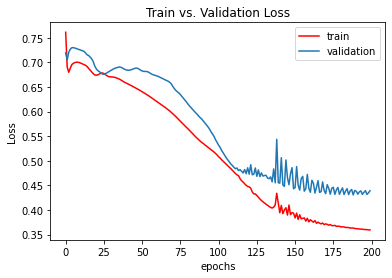

Train Accuracy 86.89%
Validation Accuracy 75.00%


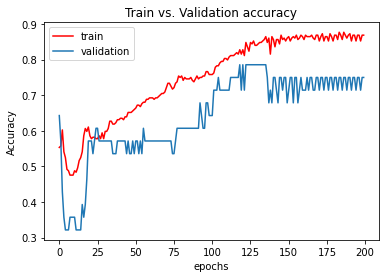

Train AUC 0.87
Validation AUC 0.69


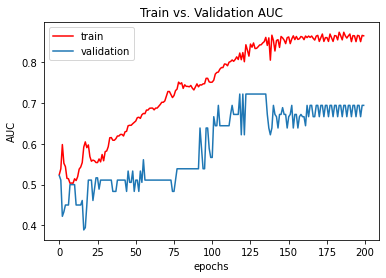

test accuracy: 80.645%


In [32]:
heartNet = network(x_train, x_validation, y_train, y_validation, n_iters=200, n_hidden=5, learning_rate=0.01)
print(heartNet.net)
heartNet.train()
heartNet.plot_train_and_test_loss()
heartNet.plot_train_and_test_AUC()
test_accuracy=heartNet.calculate_test_accuracy(x_test,y_test.to_numpy())
print(f'test accuracy: {round(test_accuracy,5)*100}%')

test accuracy with 2 nodes in hidden layers: 54.839000000000006%
test accuracy with 3 nodes in hidden layers: 54.839000000000006%
test accuracy with 4 nodes in hidden layers: 80.645%
test accuracy with 5 nodes in hidden layers: 80.645%
test accuracy with 6 nodes in hidden layers: 83.871%
test accuracy with 7 nodes in hidden layers: 87.09700000000001%
test accuracy with 8 nodes in hidden layers: 80.645%
test accuracy with 9 nodes in hidden layers: 83.871%
test accuracy with 10 nodes in hidden layers: 80.645%
test accuracy with 11 nodes in hidden layers: 77.41900000000001%
test accuracy with 12 nodes in hidden layers: 83.871%
test accuracy with 13 nodes in hidden layers: 77.41900000000001%
test accuracy with 14 nodes in hidden layers: 77.41900000000001%
test accuracy with 15 nodes in hidden layers: 80.645%
test accuracy with 16 nodes in hidden layers: 80.645%
test accuracy with 17 nodes in hidden layers: 83.871%
test accuracy with 18 nodes in hidden layers: 83.871%
test accuracy with 19 

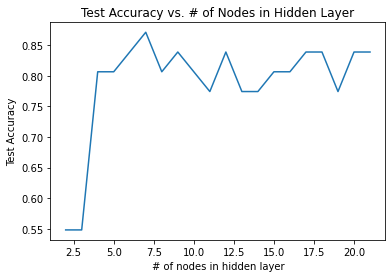

In [7]:
test_accuracy_arr=[]
x_values_arr=[]
for i in range(20):
  hiddenLayers=i+2
  heartNet = network(x_train, x_validation, y_train, y_validation, n_iters=200, n_hidden=hiddenLayers, learning_rate=0.01)
  #print(heartNet.net)
  heartNet.train()
  #heartNet.plot_train_and_test_loss()
  #heartNet.plot_train_and_test_AUC()
  test_accuracy=heartNet.calculate_test_accuracy(x_test,y_test.to_numpy())
  test_accuracy_arr.append(test_accuracy)
  x_values_arr.append(hiddenLayers)
  print(f'test accuracy with {(i+2)} nodes in hidden layers: {round(test_accuracy,5)*100}%')

plt.plot(x_values_arr, test_accuracy_arr)
plt.xlabel("# of nodes in hidden layer")
plt.ylabel("Test Accuracy")
plt.title('Test Accuracy vs. # of Nodes in Hidden Layer')
plt.show()

test accuracy with 0.005 learning rate and 7 nodes in hidden layers: 77.41900000000001%
test accuracy with 0.01 learning rate and 7 nodes in hidden layers: 87.09700000000001%
test accuracy with 0.015 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 0.02 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 0.025 learning rate and 7 nodes in hidden layers: 83.871%
test accuracy with 0.030000000000000002 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 0.034999999999999996 learning rate and 7 nodes in hidden layers: 54.839000000000006%
test accuracy with 0.04 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 0.045 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 0.049999999999999996 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 0.055 learning rate and 7 nodes in hidden layers: 77.41900000000001%
test accuracy with 0.06 learning rate and 7 nodes in hidden layers

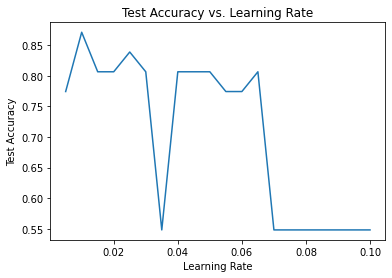

In [8]:
test_accuracy_arr=[]
x_values_arr=[]
for i in range(20):
  learningRate=0.005+i*0.005
  heartNet = network(x_train, x_validation, y_train, y_validation, n_iters=200, n_hidden=7, learning_rate=learningRate)
  #print(heartNet.net)
  heartNet.train()
  #heartNet.plot_train_and_test_loss()
  #heartNet.plot_train_and_test_AUC()
  test_accuracy=heartNet.calculate_test_accuracy(x_test,y_test.to_numpy())
  test_accuracy_arr.append(test_accuracy)
  x_values_arr.append(learningRate)
  print(f'test accuracy with {learningRate} learning rate and 7 nodes in hidden layers: {round(test_accuracy,5)*100}%')

plt.plot(x_values_arr, test_accuracy_arr)
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
plt.title('Test Accuracy vs. Learning Rate')
plt.show()

test accuracy with 25 iterations, 0.01 learning rate and 7 nodes in hidden layers: 54.839000000000006%
test accuracy with 50 iterations, 0.01 learning rate and 7 nodes in hidden layers: 54.839000000000006%
test accuracy with 75 iterations, 0.01 learning rate and 7 nodes in hidden layers: 54.839000000000006%
test accuracy with 100 iterations, 0.01 learning rate and 7 nodes in hidden layers: 58.065%
test accuracy with 125 iterations, 0.01 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 150 iterations, 0.01 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 175 iterations, 0.01 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 200 iterations, 0.01 learning rate and 7 nodes in hidden layers: 87.09700000000001%
test accuracy with 225 iterations, 0.01 learning rate and 7 nodes in hidden layers: 83.871%
test accuracy with 250 iterations, 0.01 learning rate and 7 nodes in hidden layers: 80.645%
test accuracy with 275 iterations, 0

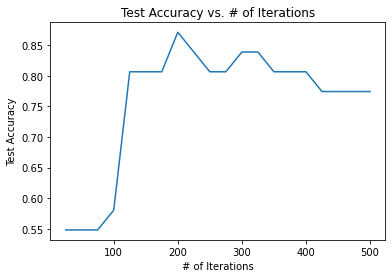

In [9]:
test_accuracy_arr=[]
x_values_arr=[]
for i in range(20):
  iterations=25+i*25
  heartNet = network(x_train, x_validation, y_train, y_validation, n_iters=iterations, n_hidden=7, learning_rate=0.01)
  #print(heartNet.net)
  heartNet.train()
  #heartNet.plot_train_and_test_loss()
  #heartNet.plot_train_and_test_AUC()
  test_accuracy=heartNet.calculate_test_accuracy(x_test,y_test.to_numpy())
  test_accuracy_arr.append(test_accuracy)
  x_values_arr.append(iterations)
  print(f'test accuracy with {iterations} iterations, 0.01 learning rate and 7 nodes in hidden layers: {round(test_accuracy,5)*100}%')

plt.plot(x_values_arr, test_accuracy_arr)
plt.xlabel("# of Iterations")
plt.ylabel("Test Accuracy")
plt.title('Test Accuracy vs. # of Iterations')
plt.show()

new best test accuracy with 25 iterations, 0.005 learning rate and 2 nodes in hidden layers: 54.839000000000006%
finished checking 2 hiddenLayers with learning rate 0.005
finished checking 3 hiddenLayers with learning rate 0.005
new best test accuracy with 25 iterations, 0.005 learning rate and 4 nodes in hidden layers: 61.29%
new best test accuracy with 50 iterations, 0.005 learning rate and 4 nodes in hidden layers: 70.968%
new best test accuracy with 75 iterations, 0.005 learning rate and 4 nodes in hidden layers: 83.871%
finished checking 4 hiddenLayers with learning rate 0.005
new best test accuracy with 150 iterations, 0.005 learning rate and 5 nodes in hidden layers: 87.09700000000001%
finished checking 5 hiddenLayers with learning rate 0.005
finished checking 6 hiddenLayers with learning rate 0.005
finished checking 7 hiddenLayers with learning rate 0.005
finished checking 8 hiddenLayers with learning rate 0.005
finished checking 9 hiddenLayers with learning rate 0.005
finished

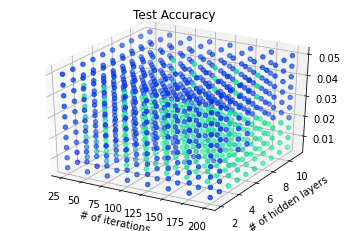

In [35]:
test_accuracy_arr=[]
params=[]
layers_arr=[]
learning_rate_arr=[]
iterations_arr=[]
loss_arr=[]
bestAccuracy=0
bestIterations=0
bestLayers=0
bestLearningRate=0

y_test_t=torch.FloatTensor(y_test.to_numpy().reshape(-1, 1))

for i in range(10):
  learningRate=0.005+i*0.005
  for j in range(10):
    hiddenLayers=j+2
    for k in range(8):
      currentIndex+=1
      iterations=25+k*25
      heartNet = network(x_train, x_validation, y_train, y_validation, n_iters=iterations, n_hidden=hiddenLayers, learning_rate=learningRate)
      heartNet.train()
      test_accuracy=heartNet.calculate_test_accuracy(x_test,y_test.to_numpy())
      y_hat=heartNet.predict_test(x_test)
      test_loss=heartNet.loss_func(y_hat, y_test_t)
      loss_arr.append(test_loss)
      num_of_parameters=sum(p.numel() for p in heartNet.net.parameters() if p.requires_grad)
      params.append(num_of_parameters)
      
      test_accuracy_arr.append(test_accuracy)
      iterations_arr.append(iterations)
      layers_arr.append(hiddenLayers)
      learning_rate_arr.append(learningRate)
      #print(f'test accuracy with {iterations} iterations, {learningRate} learning rate and {hiddenLayers} nodes in hidden layers: {round(test_accuracy,5)*100}%')

      if bestAccuracy<test_accuracy:
        bestAccuracy=test_accuracy
        bestIterations=iterations
        bestLayers=hiddenLayers
        bestLearningRate=learningRate
        print(f'new best test accuracy with {iterations} iterations, {learningRate} learning rate and {hiddenLayers} nodes in hidden layers: {round(test_accuracy,5)*100}%')
      if bestAccuracy==test_accuracy:
        bestSetupsIndices.append(currentIndex)
    
    print(f'finished checking {hiddenLayers} hiddenLayers with learning rate {learningRate}')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(iterations_arr,layers_arr,learning_rate_arr, c=test_accuracy_arr, cmap='winter')
plt.xlabel("# of iterations")
plt.ylabel("# of hidden layers")
#plt.zlabel("learning rate")
plt.title('Test Accuracy')
plt.show()

In [47]:
def calc_aic(n,num_params,loss):
  return n * np.log(loss) + 2 * num_params

def calc_bic(n, num_params, loss):
	bic = n * np.log(loss) + num_params * np.log(n)
	return bic

87.1% accuracy with 150 iterations, 0.005 learning rate and 5 nodes in hidden layers. Loss 0.4216243326663971, # of params: 106, aic: 185.22714233398438, bic: 337.22979736328125
87.1% accuracy with 125 iterations, 0.005 learning rate and 9 nodes in hidden layers. Loss 0.4613324701786041, # of params: 226, aic: 428.01727294921875, bic: 752.098388671875
87.1% accuracy with 100 iterations, 0.01 learning rate and 5 nodes in hidden layers. Loss 0.454110711812973, # of params: 106, aic: 187.5281524658203, bic: 339.53082275390625
87.1% accuracy with 200 iterations, 0.01 learning rate and 7 nodes in hidden layers. Loss 0.4339844584465027, # of params: 162, aic: 298.12286376953125, bic: 530.4287719726562
87.1% accuracy with 75 iterations, 0.01 learning rate and 9 nodes in hidden layers. Loss 0.452497661113739, # of params: 226, aic: 427.4178466796875, bic: 751.4989624023438
87.1% accuracy with 50 iterations, 0.015 learning rate and 4 nodes in hidden layers. Loss 0.42171838879585266, # of params

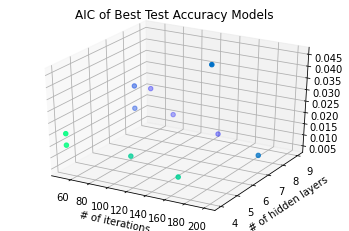

In [60]:
n=len(y_test)
best_iterations_arr=[]
best_layers_arr=[]
best_learning_rate_arr=[]
aics=[]
for i in range(len(test_accuracy_arr)):
  if bestAccuracy==test_accuracy_arr[i]:
    best_iterations_arr.append(iterations_arr[i])
    best_layers_arr.append(layers_arr[i])
    best_learning_rate_arr.append(learning_rate_arr[i])

    aic=calc_aic(n,params[i],loss_arr[i])
    bic=calc_bic(n,params[i],loss_arr[i])

    aics.append(aic*-1)
    print(f'{round(test_accuracy_arr[i],4)*100}% accuracy with {iterations_arr[i]} iterations, {learning_rate_arr[i]} learning rate and {layers_arr[i]} nodes in hidden layers. Loss {loss_arr[i]}, # of params: {params[i]}, aic: {aic}, bic: {bic}')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(best_iterations_arr,best_layers_arr,best_learning_rate_arr, c=aics, cmap='winter')
plt.xlabel("# of iterations")
plt.ylabel("# of hidden layers")
#plt.zlabel("learning rate")
plt.title('AIC of Best Test Accuracy Models')
plt.show()